In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import cv2
from PIL import Image

# Loading all the models

In [4]:
haar = cv2.CascadeClassifier('data/model/haarcascade_frontalface_default.xml')
# pickle files
mean = pickle.load(open('data/model/mean_preprocess.pickle', 'rb'))
model_svm = pickle.load(open('model_svm.pickle', 'rb'))
model_pca = pickle.load(open('data/pca_50.pickle', 'rb'))

print("Model loaded succesfully")

Model loaded succesfully


In [5]:
print(mean.shape)

(10000,)


In [6]:
gender_pre = ['Male', 'Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [52]:
def pipeline_model(img, color='rgb'):
    
    # Step 2: convert into grayscale
    if color == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 3: crop face from image using Haar Cascade Classifier
    faces = haar.detectMultiScale(gray, 1.5, 3)
    
    for x, y, w, h in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 2) # draw rectangle
        roi = gray[y:y+h, x:x+w] # crop image
    
        # Step 4: normalization (0-1)
        roi = roi / 255.0
        
        # Step 5: resize image into 100 x 100 array
        if roi.shape[1] > 100:
            roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi, (100, 100), cv2.INTER_CUBIC)
        
        #Step 6: flattening (1x10,000)
        roi_reshape = roi_resize.reshape(1,10000) # 1, -1
        
        # Step 7: subtract with mean
        roi_mean = roi_reshape - mean
        
        # Step 8: get eigen image - apply PCA model
        eigen_image = model_pca.transform(roi_mean)
        
        # Step 9: pass to ML Model (SVM)
        results = model_svm.predict_proba(eigen_image)[0]
        
        # Step 10: 
        predict = results.argmax() # 0 (male) or 1 (female)
        score = results[predict]
        
        # Step 11:
        text = f"{gender_pre[predict]} : {score:.2f}"
        cv2.putText(img, text, (x,y-25), font, 1, (0, 255, 0), 2)

    return img

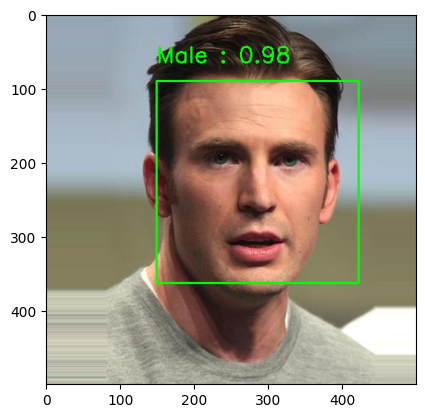

In [67]:
# Test data
test_data_path = 'data/male_test.jpg'
# color = 'bgr'all

# Step 1.1: read image
# img = cv2.imread(test_data_path)
img = Image.open(test_data_path)

# Step 1.2: convert into array
img = np.array(img)

#Step 1.3: pass to pipeline model
img = pipeline_model(img)

plt.imshow(img)
# cv2.imshow('Gender Prediction', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Apply Pipeline to Video

In [86]:
cap = cv2.VideoCapture('data/video_1.mp4')

while True:
    ret, frame = cap.read() # bgr

    if ret is False:
        break

    iframemg = pipeline_model(frame, 'bgr')
    
    cv2.imshow("Gender Detection", frame)

    # if cv2.waitKey(20) == 27: # esc key
    if cv2.waitKey(10) == ord('s'): # 's' key 
        break

cv2.destroyAllWindows()
cap.release()